# GP regression to calculate the mean of the time series and the 95% CI of the mean, using sklearn

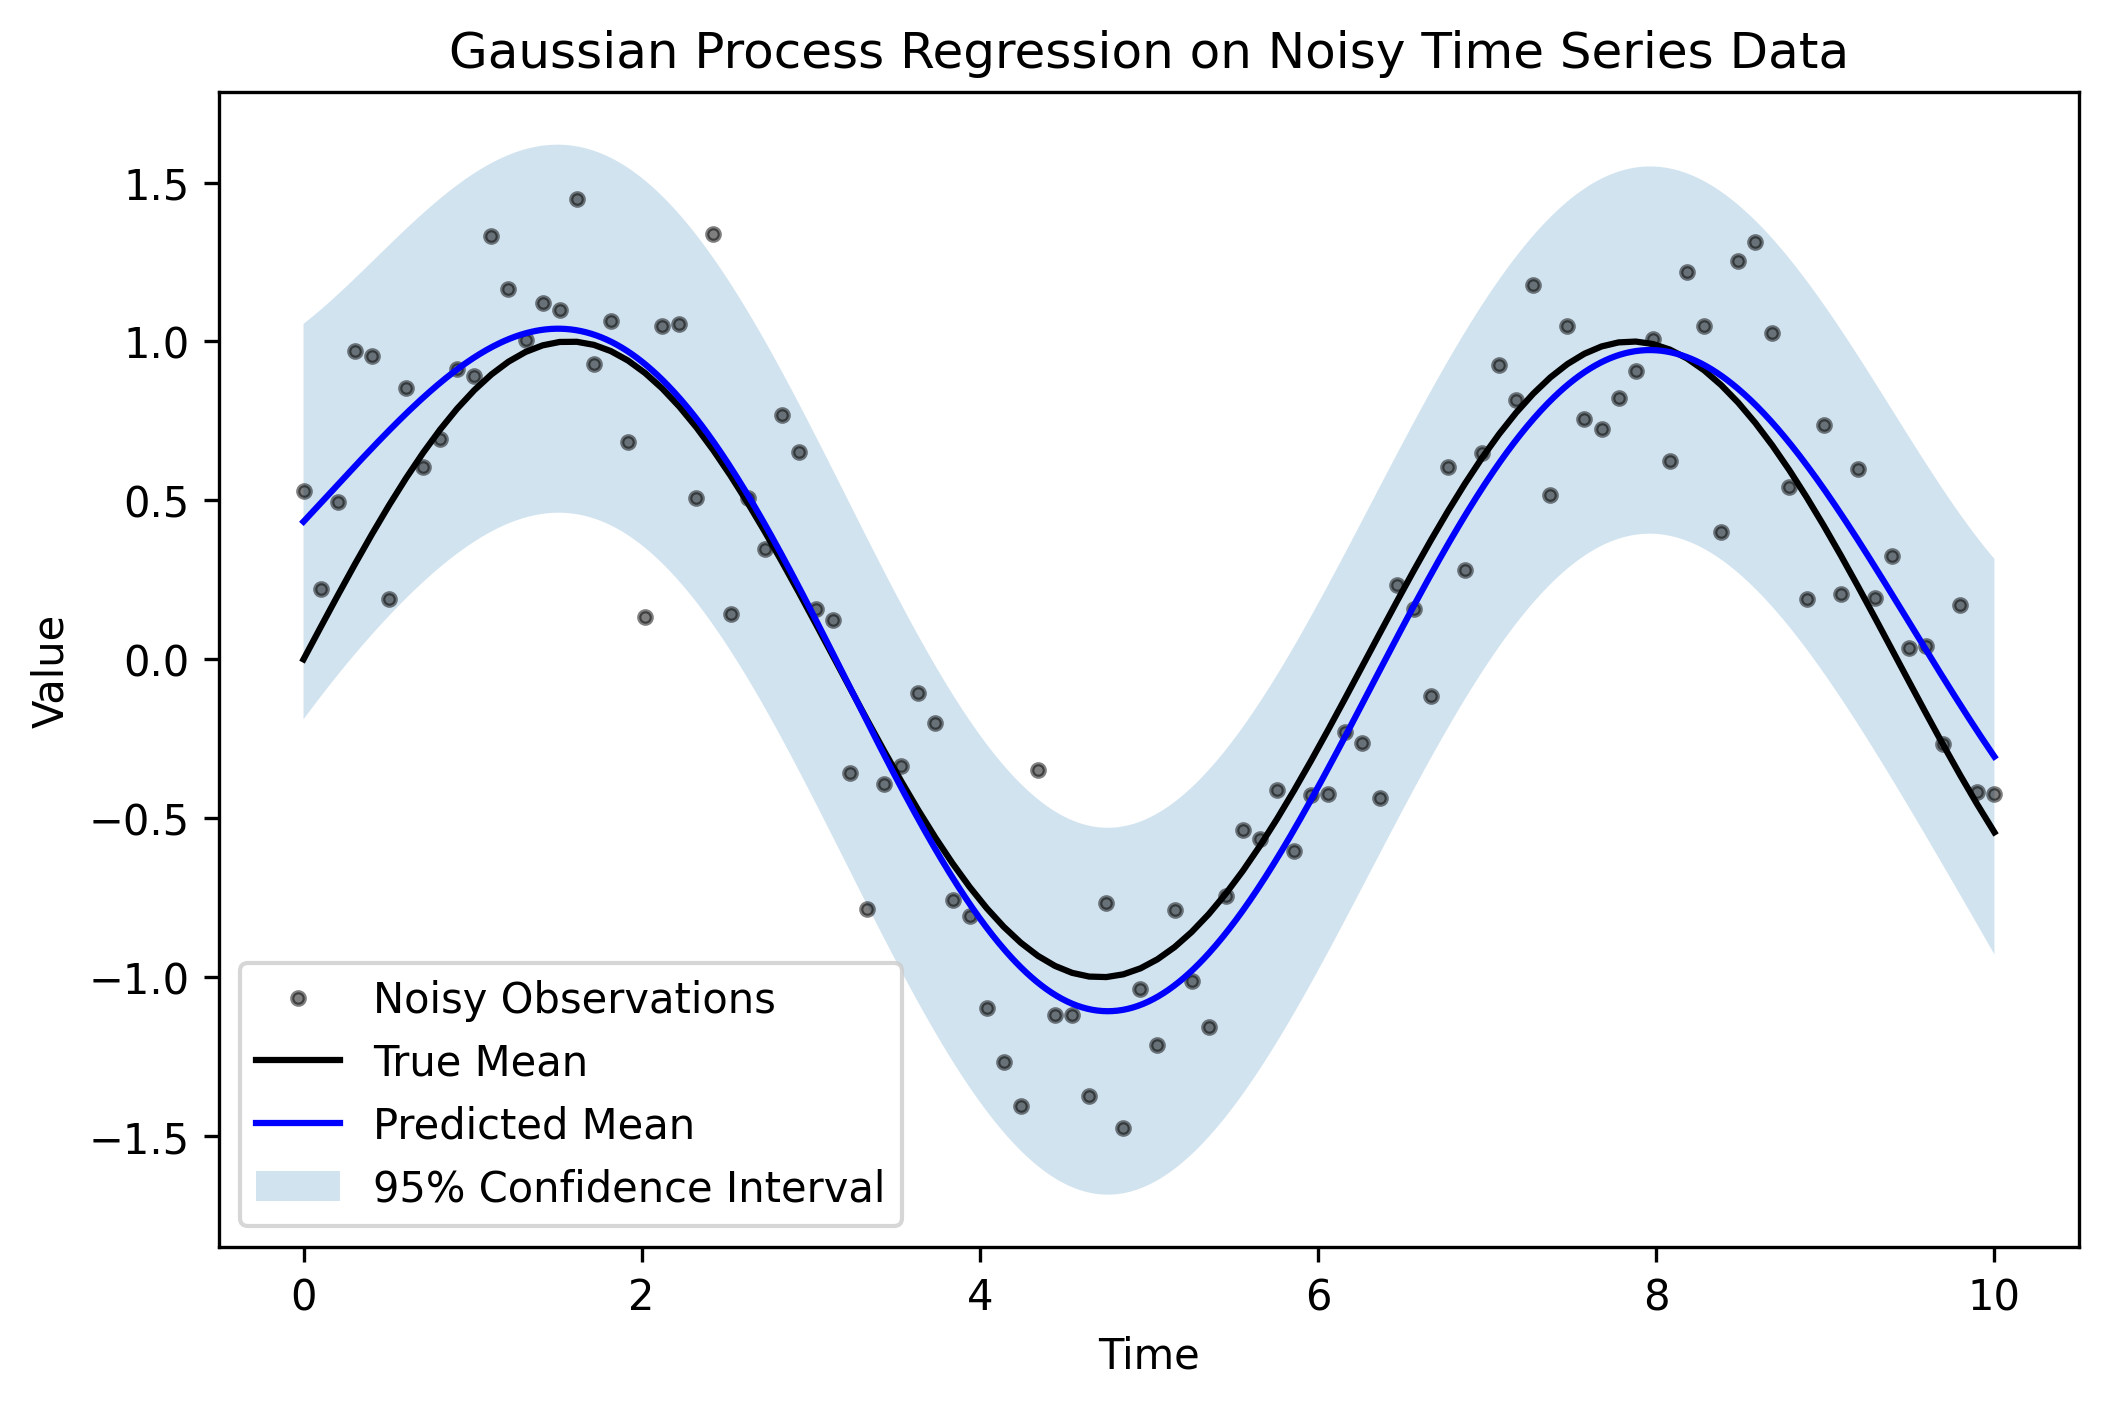

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import numpy as np
import matplotlib.pyplot as plt

# Generating synthetic time series data (the training data)
np.random.seed(0)
time_series_length = 100
time = np.linspace(0, 10, time_series_length)
true_function = np.sin(time)
noise = np.random.normal(0, 0.3, time_series_length)
noisy_data = true_function + noise

# Reshape data for scikit-learn
X = time.reshape(-1, 1)
y = noisy_data

# Define Gaussian Process model
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit GP model
gp.fit(X, y)

# Make predictions
X_pred = np.linspace(0, 10, 1000).reshape(-1, 1)
# X_pred=X
y_pred, sigma = gp.predict(X_pred, return_std=True) 

# Plotting
plt.figure(figsize=(8, 5),dpi=300)
plt.plot(time, noisy_data, 'ok', markersize=3, alpha=0.5, label='Noisy Observations')
# plot the true mean
plt.plot(time, true_function, 'k', label='True Mean')
plt.plot(X_pred, y_pred, 'b', label='Predicted Mean')
# Plot scatters of the X_pred and y_pred
# plt.plot(X_pred, y_pred, 'b.', markersize=10, label='Predicted Values')
# Here the 95% CI indicates the range within which the method expect the true mean function (or the mean time series) to lie with 95% probability. 
plt.fill_between(X_pred.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Gaussian Process Regression on Noisy Time Series Data')
plt.legend()
plt.show()



# GP regression to calculate the mean of the time series and the 95% CI of the mean, using custom function

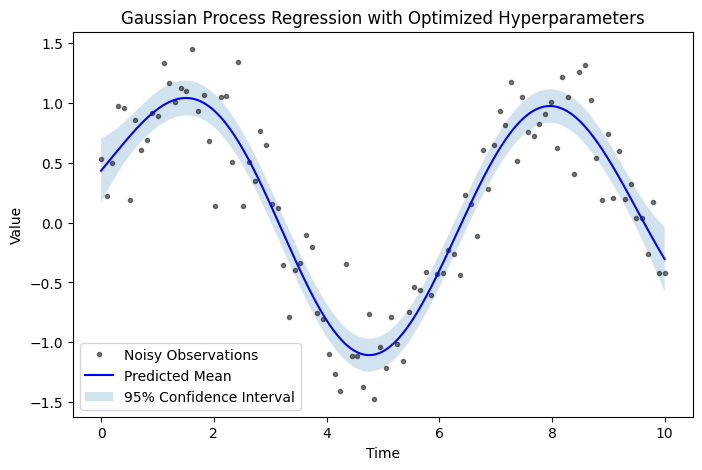

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Radial Basis Function (RBF) kernel (Gaussian kernel)
def rbf_kernel(X1, X2, length_scale=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return np.exp(-0.5 / length_scale**2 * sqdist)

# Log Marginal Likelihood
def log_marginal_likelihood(params, X_train, y_train):
    length_scale, noise_level = params
    K = rbf_kernel(X_train, X_train, length_scale) + noise_level**2 * np.eye(len(X_train))
    K_inv = np.linalg.inv(K)
    LML = -0.5 * np.dot(y_train.T, np.dot(K_inv, y_train)) - 0.5 * np.log(np.linalg.det(K)) - len(X_train) / 2 * np.log(2 * np.pi)
    return -LML

# Optimize hyperparameters
def optimize_hyperparameters(X_train, y_train, initial_params=[1.0, 0.1]):
    result = minimize(log_marginal_likelihood, initial_params, args=(X_train, y_train), bounds=((1e-5, None), (1e-5, None)))
    return result.x

# Gaussian Process Regression Function
def basic_gp_regression(X_train, y_train, X_test, length_scale, noise_level):
    K = rbf_kernel(X_train, X_train, length_scale) + noise_level**2 * np.eye(len(X_train))
    K_s = rbf_kernel(X_train, X_test, length_scale)
    K_ss = rbf_kernel(X_test, X_test, length_scale) + 1e-8 * np.eye(len(X_test))
    K_inv = np.linalg.inv(K)
    mu_s = np.dot(K_s.T, np.dot(K_inv, y_train))
    cov_s = K_ss - np.dot(K_s.T, np.dot(K_inv, K_s))
    return mu_s, cov_s

# Generating synthetic time series data
np.random.seed(0)
time_series_length = 100
time = np.linspace(0, 10, time_series_length)
true_function = np.sin(time)
noise = np.random.normal(0, 0.3, time_series_length)
noisy_data = true_function + noise

# Reshape data for the GP
X = time.reshape(-1, 1)
y = noisy_data

# Optimize hyperparameters
optimized_params = optimize_hyperparameters(X, y)
optimized_length_scale, optimized_noise_level = optimized_params

# GP regression with optimized parameters
X_test = np.linspace(0, 10, 1000).reshape(-1, 1)
mu_s_opt, cov_s_opt = basic_gp_regression(X, y, X_test, optimized_length_scale, optimized_noise_level)

# Standard deviation (uncertainty) for confidence intervals
sigma_opt = np.sqrt(np.diag(cov_s_opt))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(time, noisy_data, 'ok', markersize=3, alpha=0.5, label='Noisy Observations')
plt.plot(X_test, mu_s_opt, 'b', label='Predicted Mean')
plt.fill_between(X_test.ravel(), mu_s_opt.ravel() - 1.96 * sigma_opt, mu_s_opt.ravel() + 1.96 * sigma_opt, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Gaussian Process Regression with Optimized Hyperparameters')
plt.legend()
plt.show()
